In [1]:
import tensorflow as tf

### Configuration
create_dataset = True

def in_google_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Get the platform
if in_google_colab():
    print("Running in Google Colab")
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !pip install vitaldb
    directory = 'anesthesia_anomaly_detection/data/'
    create_dataset = False
else:
    print("Running locally")
    directory = 'data/'

### Datasetpath
datasetpath = 'dataset02/'
vitaldbpath = 'vitaldb_tiva/'

import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt

Running locally


In [2]:
from scipy import ndimage

def outlierfilter(data: pd.DataFrame,threshhold: float, iterations: int, min: float, max: float):
    """
    A filter function, which calculates the gradient of a given Pandas DataFram Timeseries
    and performs a binary dilation on datapoints which exceed a certain treshhold, to detect
    and remove unwanted outliers in the dataset. Additionally all values exceeding a given
    min/max value are replaced with np.nan and linearly interpolated with the Pandas interpolate
    method.

    Args:
        data (pd.DataFrame): Timeseries Data
        threshhold (float): Gradient thresshold
        iterations (int): number of iterations of the binary dilation
        min (float): maximum expected value
        max (float): minimum expected value

    Returns:
        pd.DataFrame: _description_
    """
    gradient = np.diff(data,n=1, axis=0, append=0)
    gradientfilter = ndimage.binary_dilation(np.abs(gradient) > threshhold, iterations=iterations)

    # Apply Filter
    data[gradientfilter] = np.nan

    data[data <= min] = np.nan
    data[data > max] = np.nan

    data = data.interpolate(method = 'linear')
    data = data.bfill()
    return data

### Custom Normalization Functions

def NormStandard(dataset: np.array):
    mean = np.nanmean(dataset)
    std = np.nanstd(dataset)
    return (dataset - mean) / std

def NormMinMax(dataset: np.array):
    min = np.min(dataset)
    max = np.max(dataset)
    return (dataset - min) / (max - min)

def NormCustomBIS(dataset: np.array):
    return (100 - dataset) / 100

def NormNone(dataset: np.array):
    return dataset

In [3]:
from os import listdir
from sklearn.model_selection import train_test_split

class DatasetImport():
    def __init__(self, directory: str, dataset: str, vitalpath: str, interval: int = 10):
        self.directory = directory
        self.datasetpath = directory + dataset
        self.vitalpath = directory + vitalpath

        self.interval = interval

        self.train_dataset = None
        self.validation_dataset = None
        self.test_dataset = None

        self.index = pd.read_csv(self.datasetpath +'dataset.csv', index_col=0).index.to_numpy()

    def save(self, filename: str):
        np.savez_compressed(self.datasetpath+filename,
                            train = self.train_dataset,
                            validation = self.validation_dataset,
                            test = self.test_dataset,
                            timesteps = self.timesteps,
                            )

    def load(self, filename: str):
        data = np.load(self.datasetpath+filename)
        self.train_dataset = data['train']
        self.validation_dataset = data['validation']
        self.test_dataset = data['test']
        try:
            self.timesteps = data['timesteps']
        except:
            self.timesteps = []

    def split(self,data):
       train, test = train_test_split(data, test_size=0.15, random_state=42)
       train, validation = train_test_split(train, test_size=0.15, random_state=42)
       return train, validation, test

    def generateDataset(self, normalization):

        dataset, self.timesteps = self.generate(self.index, normalization)

        self.train_dataset, self.validation_dataset, self.test_dataset = self.split(dataset)
        print('Dataset succesfully generated                 ')

    def generate(self, dataset_index: list, normalization):
        batch_list = []
        timesteps = []

        for i, caseid in enumerate(dataset_index):
            filepath = self.vitalpath+str(caseid).zfill(4)+'.vital'
            data, importName = self.importFunction(filepath)
            timesteps.append(data.shape[0])
            batch_list.append(data)
            print(importName + " Fortschritt: %.1f" % (100 * (i+1) / len(dataset_index)),' % ', end='\r')

        ### Pad the dataset
        data = tf.keras.preprocessing.sequence.pad_sequences(batch_list, padding='post', dtype='float32', value=0.0)

        # Remove 0.0 padded values
        data[data == 0.0] = np.nan

        # Nomalization
        data = normalization(data)

        # restore padded values
        np.nan_to_num(data, copy=False, nan=0.0)

        return data, np.array(timesteps)

    def importFunction(self, filepath: str):
        return None, None

class infoImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

        self.columns = ['sex','age','height','weight','bmi']

    def generate(self, dataset_index: list, normalization):

        data = pd.read_csv(self.directory+'info_vitaldb/cases.csv', index_col=0)
        data = data[self.columns].loc[dataset_index].to_numpy()

        sex = np.where(data[:, 0] == 'F', -0.5, 0.5)

        data = data[:,1:].astype(float)
        data = np.c_[sex, normalization(data)]

        return data, None

class VitalImport(DatasetImport):
    def __init__(self, directory: str, dataset: str, vitalpath: str):
        super().__init__(directory,dataset,vitalpath)

        self.tracks = []
        self.filter = [0,0,0]
        self.name = 'Vital'

    def importFunction(self, filepath: str):

        vitaldata = vf.VitalFile(ipath = filepath, track_names = self.tracks)

        data = vitaldata.to_pandas(track_names=self.tracks,interval=self.interval)
        data = data + 0.00001 # adds small value to avoid mix up with padding values
        data = outlierfilter(data, threshhold = self.filter[0] , iterations = 2, min = self.filter[1], max = self.filter[2])

        return data, self.name

In [4]:
info = infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

bis = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

propofolrate = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolrate.load('03_propofol_rate.npz')

propofolvol = VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolvol.load('03_propofol_vol.npz')

In [ ]:
#plt.plot(propofolrate.train_dataset[i])
plt.plot(np.convolve(bis.train_dataset[i,:,0], np.ones(10)/10, mode='valid'))
#plt.plot((propofolrate.train_dataset == 0.00001)[i]*50)
#plt.plot(propofolrate.train_dataset[i,])
#plt.plot(propofolvol.train_dataset[i])
plt.axis([0, 2000, 0, 100])
print(propofolrate.train_dataset[i,1250,:])
index1 = np.argmax(conv < 40) + N
index2 = np.argmax((conv < 2) & (conv > 0.00001)) - N
plt.vlines(index1, 0, 100, colors='r')
plt.vlines(index2, 0, 100, colors='g')

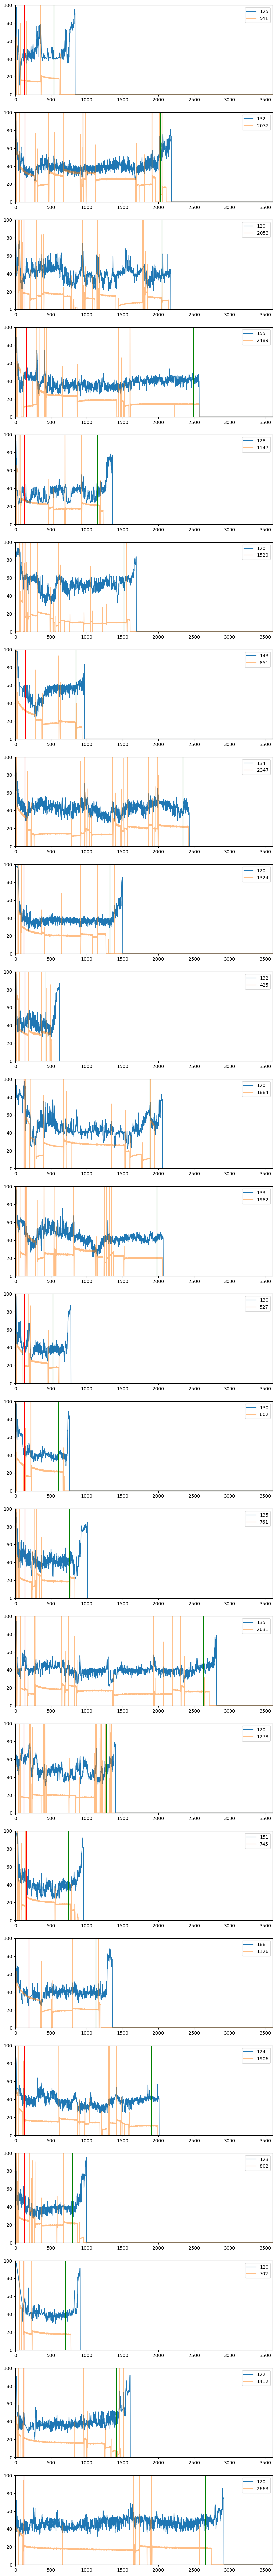

In [109]:
N = 60 # Number of samples to average 10min

train_index, val_index, test_index = bis.split(np.array(bis.index))

fig, axs = plt.subplots(bis.test_dataset.shape[0], 1, figsize=(10, 100))

for i, filename in enumerate(test_index):
    conv = np.convolve(propofolrate.test_dataset[i,:,0], np.ones(N)/N, mode='valid')
    axs[i].plot(bis.test_dataset[i,:,0])
    axs[i].plot(propofolrate.test_dataset[i,:,0], alpha=0.5)

    axs[i].axis([0, 3600, 0, 100])

    index1 = np.argmax(conv < 40) + 2 * N
    index2 = np.where(conv > 5)[0][-1] - N

    axs[i].vlines(index1, 0, 100, colors='r')
    axs[i].vlines(index2, 0, 100, colors='g')

    axs[i].legend([index1,index2])

In [117]:
for i in propofolrate.test_dataset:
    print(i.shape)

(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)
(3680, 1)


In [119]:
bis.index.shape

(155,)

In [133]:
def get_anesthesia_phases(dataset: np.array, index: np.array, N: int = 60):
    """
    A function to detect the anesthesia phases in a given dataset. The function calculates the
    moving average of the propofol rate and detects the start and end of the anesthesia phases
    by detecting the first and last occurence of a propofol rate below 40 ml/h and above 5 ml/h.

    Args:
        data (np.array): Propofol rate dataset
        N (int): Number of samples to average

    Returns:
        dict: Dict where each key contains a List of the end index of induction and start index of the recovery phases
    """
    anesthesia_phases = {}
    
    for i, data in zip(index, dataset):
        conv = np.convolve(data[:,0], np.ones(N)/N, mode='valid')
        index1 = np.argmax(conv < 40) + 2 * N
        index2 = np.where(conv > 5)[0][-1] - N
        anesthesia_phases[i] = [index1, index2]
    return anesthesia_phases

In [134]:
get_anesthesia_phases(propofolrate.test_dataset, test_index)

{2248: [125, 541],
 963: [132, 2032],
 3270: [120, 2053],
 5837: [155, 2489],
 3167: [128, 1147],
 3325: [120, 1520],
 3500: [143, 851],
 2332: [134, 2347],
 1768: [120, 1324],
 4012: [132, 425],
 4987: [120, 1884],
 3930: [133, 1982],
 3564: [130, 527],
 1826: [130, 602],
 5680: [135, 761],
 5319: [135, 2631],
 4027: [120, 1278],
 3379: [151, 745],
 70: [188, 1126],
 4258: [124, 1906],
 167: [123, 802],
 1925: [120, 702],
 5224: [122, 1412],
 4644: [120, 2663]}

In [ ]:
j = 4
train_index, val_index, test_index = bis.split(np.array(bis.index))
time = np.arange(0, bis.test_dataset[j].shape[0]) * 10 / 60

plt.figure(figsize=(14/2.54, 6/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(time,bis.test_dataset[j], label='Ground Truth', color='k')
plt.vlines(30, 0, 100, color='r', linestyle='--')
plt.vlines(220, 0, 100, color='r', linestyle='--')

plt.fill_between([0, 30], 0, 100, color='b', alpha=0.1)
plt.fill_between([30, 220], 0, 100, color='r', alpha=0.1)
plt.fill_between([220, 250], 0, 100, color='g', alpha=0.1)
plt.text(10, 10, '1', color='k', fontsize=20)
plt.text(120, 10, '2', color='k', fontsize=20)
plt.text(230, 10, '3', color='k', fontsize=20)
plt.title('CaseID: '+str(test_index[j]))
plt.xlabel('Operationszeit $t_{OP}$')
plt.ylabel('Bispektralindex $BIS$')

plt.legend(loc='upper center')

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Limits
ax.set_ylim(bottom=0, top=100)
ax.set_xlim(left=0, right= 250)

# Einheiten auf x-Achse
xunit = 'min'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

#plt.savefig('timings_dividing.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

plt.show()

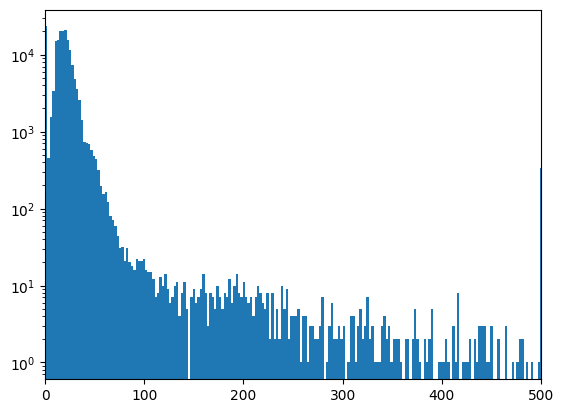

In [116]:
data = np.copy(propofolrate.train_dataset)
data[data == 0] = np.nan

plt.hist(data.flatten(), bins=500)
plt.yscale('log')

ax = plt.gca()

ax.set_xlim(left=0, right=500)
#plt.axis([0, 100, 0, 10000])
plt.show()

# OLD

In [58]:
test = {
2248: [100, 720], 
963: [200, 1900],
3270: [200, 2000], 
5837: [200, 2500],
3167: [100, 1200],
3325: [200, 1500],
3500: [200, 800],
2332: [250, 2400],
1768: [200, 1300],
4012: [100, 480],
4987: [300, 1750],
3930: [300, 2000],
3564: [100, 650],
1826: [150, 700],
5680: [100, 800],
5319: [200, 2600],
4027: [200, 1300],
3379: [200, 850],
70: [150, 1200],
4258: [200, 1900],
167: [100, 800],
1925: [200, 800],
5224:[100, 1400],
4644: [100, 2700],
}

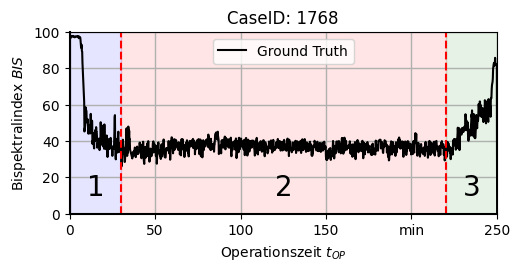

In [36]:
j = 8
train_index, val_index, test_index = bis.split(np.array(bis.index))
time = np.arange(0, bis.test_dataset[j].shape[0]) * 10 / 60

plt.figure(figsize=(14/2.54, 6/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(time,bis.test_dataset[j], label='Ground Truth', color='k')
plt.vlines(30, 0, 100, color='r', linestyle='--')
plt.vlines(220, 0, 100, color='r', linestyle='--')

plt.fill_between([0, 30], 0, 100, color='b', alpha=0.1)
plt.fill_between([30, 220], 0, 100, color='r', alpha=0.1)
plt.fill_between([220, 250], 0, 100, color='g', alpha=0.1)
plt.text(10, 10, '1', color='k', fontsize=20)
plt.text(120, 10, '2', color='k', fontsize=20)
plt.text(230, 10, '3', color='k', fontsize=20)
plt.title('CaseID: '+str(test_index[j]))
plt.xlabel('Operationszeit $t_{OP}$')
plt.ylabel('Bispektralindex $BIS$')

plt.legend(loc='upper center')

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Limits
ax.set_ylim(bottom=0, top=100)
ax.set_xlim(left=0, right= 250)

# Einheiten auf x-Achse
xunit = 'min'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

plt.savefig('timings_dividing.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

plt.show()